In [121]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [122]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [123]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [124]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [125]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1, weight_init_constant=0.01):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        #def init_weights(m):
         #   if type(m) == nn.Linear:
        #        if hasattr(m, 'weight') and m.weight is not None:
        #            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #            if m.bias is not None:
         #               init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        #self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [126]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    #train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    #test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    #train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    #test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
    loss_list = []

    batch_size = bs
    n_batches = int(len(x_train) / batch_size)
    if plot_curves:
        # Lists to store training and test losses for plotting
        train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    prev_accuracy = 0
    patience_counter, patience = 0, 50

    for epoch in range(num_epochs):
        for batch in range(n_batches):
            batch_X, batch_y = x_train[batch*batch_size:(batch+1)*batch_size,], y_train[batch*batch_size:(batch+1)*batch_size,]
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss_list.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print('\repoch: {}\tbatch: {}\tLoss =  {:.3f}'.format(epoch, batch, loss), end="")

        # Calculate training accuracy
        predicted_labels = torch.round(outputs)
        correct_predictions = (predicted_labels == batch_y).sum().item()
        total_samples = batch_y.size(0)
        train_accuracy = correct_predictions / total_samples

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Accuracy: {train_accuracy:.4f}', end='\r')

        if plot_curves:
            train_losses.append(loss.item())
            train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test accuracy
            predicted_test_labels = torch.round(test_outputs)
            correct_test_predictions = (predicted_test_labels == y_test).sum().item()
            total_test_samples = y_test.size(0)
            test_accuracy = correct_test_predictions / total_test_samples


            #print(f'Test - Epoch [{epoch+1}/{num_epochs}], Loss: {average_test_loss:.4f},'
            #       f'Accuracy: {average_test_accuracy:.4f}')
            if plot_curves:
                test_losses.append(test_loss.item())
                test_accuracies.append(test_accuracy)

        # Check for convergence
        if abs(prev_loss - loss.item()) < 1e-5:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break

        #prev_accuracy = average_accuracy
        prev_loss = loss.item()

    print(f'N. Epochs = {epoch+1} - Loss (train | test)= ({loss.item():.4} | {test_loss.item():.4}) - Accuracy (train | test) = ({train_accuracy} | {test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, loss.item(), test_loss.item(), train_accuracy, test_accuracy

In [127]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [128]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=1000,
                                         plot_curves=False, N = 5):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')


# Monk 1

In [137]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation

inizialmente modificare gli iperparametri ad occhio per avere un'idea di cosa succede,
poi fare una grid search più fine 

hidden_size=5; lr=0.2; alpha = 0.8; batch size = 1; lambda = 0
N. Epochs = 77 - Loss (train | test)= (0.2574 | 0.2008) - Accuracy (train | test) = (0.0 | 0.52)


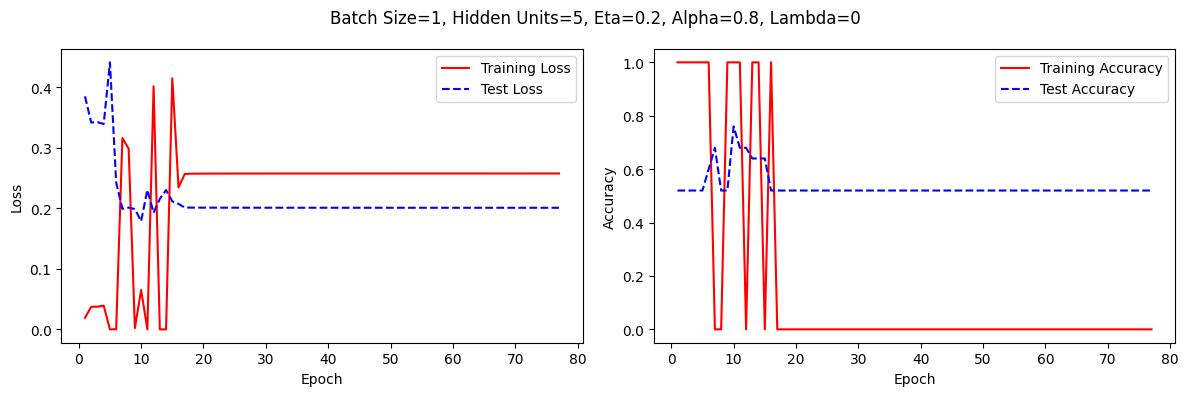

N. Epochs = 70 - Loss (train | test)= (5.154e-08 | 0.1419) - Accuracy (train | test) = (1.0 | 0.84)


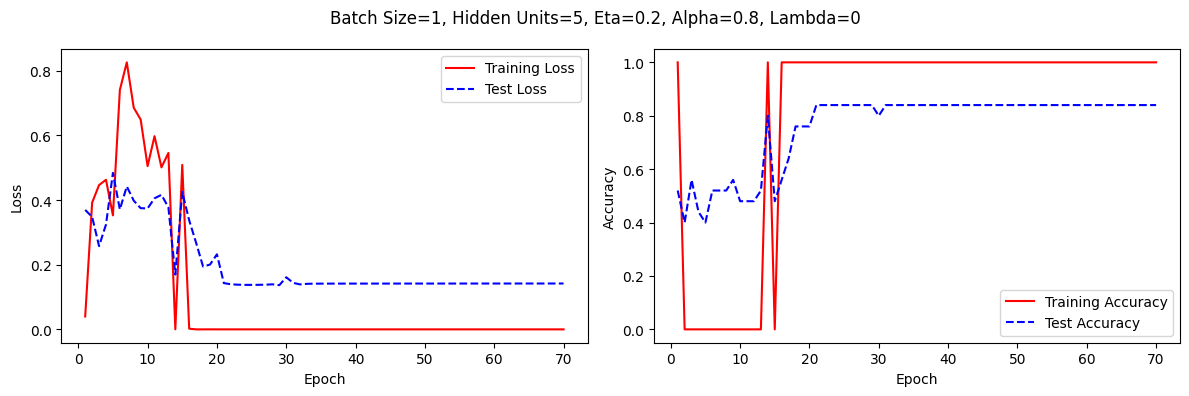

N. Epochs = 74 - Loss (train | test)= (2.341e-05 | 0.125) - Accuracy (train | test) = (1.0 | 0.88)


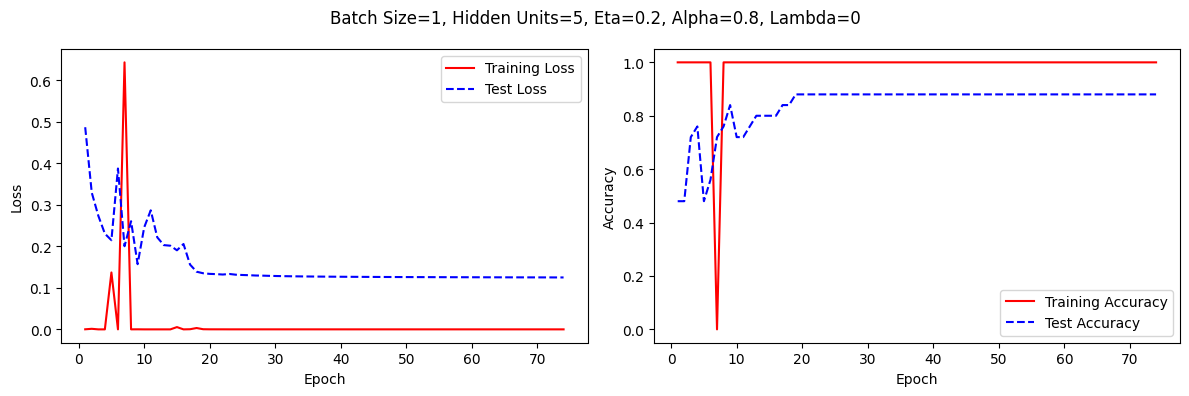

N. Epochs = 162 - Loss (train | test)= (0.03333 | 0.2694) - Accuracy (train | test) = (1.0 | 0.64)


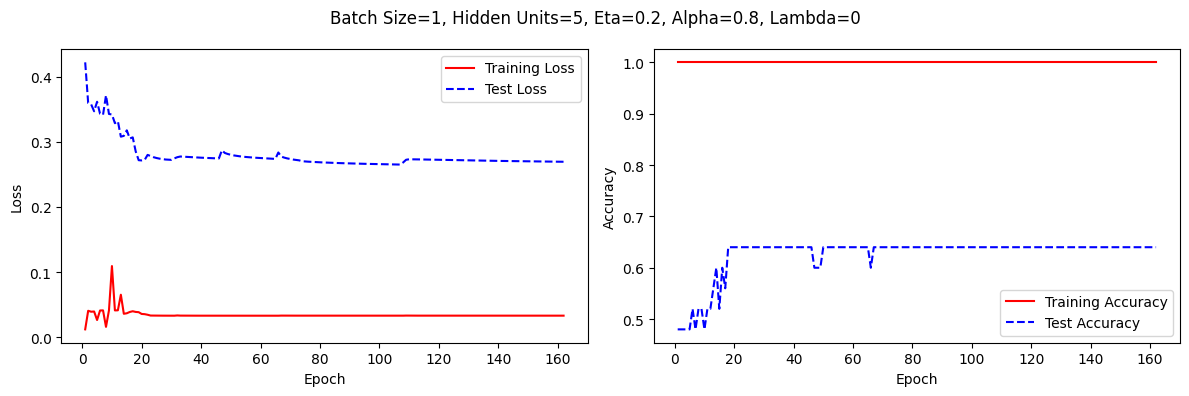

KeyboardInterrupt: 

In [140]:
hidden_sizes = [5]
learning_rates = [0.2]
momentums = [0.8]
batch_sizes = [1]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=True)

## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 276 - Loss (train | test)= (8.173e-05 | 0.04694) - Accuracy (train | test) = (1.0 | 0.9166666666666666)
N. Epochs = 199 - Loss (train | test)= (5.485e-05 | 0.0007016) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 146 - Loss (train | test)= (0.0002839 | 0.08369) - Accuracy (train | test) = (1.0 | 0.9166666666666666)


KeyboardInterrupt: 

# Retrain the model to make final plots

N. Epochs = 459 - Loss (train | test)= (0.001205 | 0.0006909) - Accuracy (train | test) = (1.0 | 1.0)


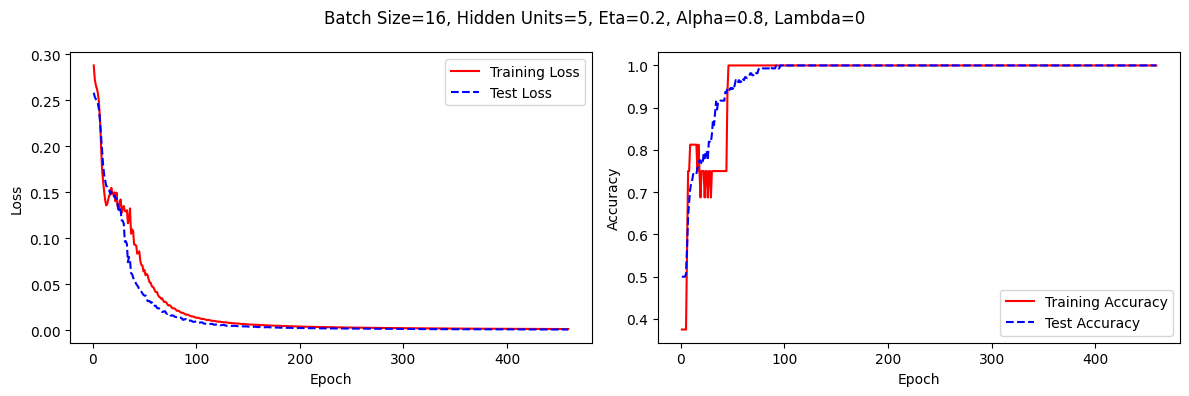

(459, 0.0012054755352437496, 0.0006908979848958552, 1.0, 1.0)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

In [ ]:
hidden_sizes = [5]
learning_rates = [0.1]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0
N. Epochs = 112 - Loss (train | test)= (0.0001409 | 0.0006229) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 195 - Loss (train | test)= (0.0004904 | 0.0003219) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 275 - Loss (train | test)= (0.0003386 | 0.000422) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 134 - Loss (train | test)= (0.0001992 | 0.0001789) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 139 - Loss (train | test)= (0.0002202 | 0.0001866) - Accuracy (train | test) = (1.0 | 1.0)
Final Results: hidden_size=5; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0 --> train_loss = 0.0002778 +- 0.0001242 | val_loss = 0.0003465 +- 0.0001652train_acc = 1.0 +- 0.0 | val_acc = 1.0 +- 0.0
[5, 0.1, 0.8, 4, 0]


In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 118 - Loss (train | test)= (0.0001387 | 0.0002229) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 109 - Loss (train | test)= (0.0001407 | 0.0001088) - Accuracy (train | test) = (1.0 | 1.0)


KeyboardInterrupt: 

epoch: 105	batch: 41	Loss =  0.000N. Epochs = 106 - Loss (train | test)= (0.0001047 | 0.0002543) - Accuracy (train | test) = (1.0 | 1.0)


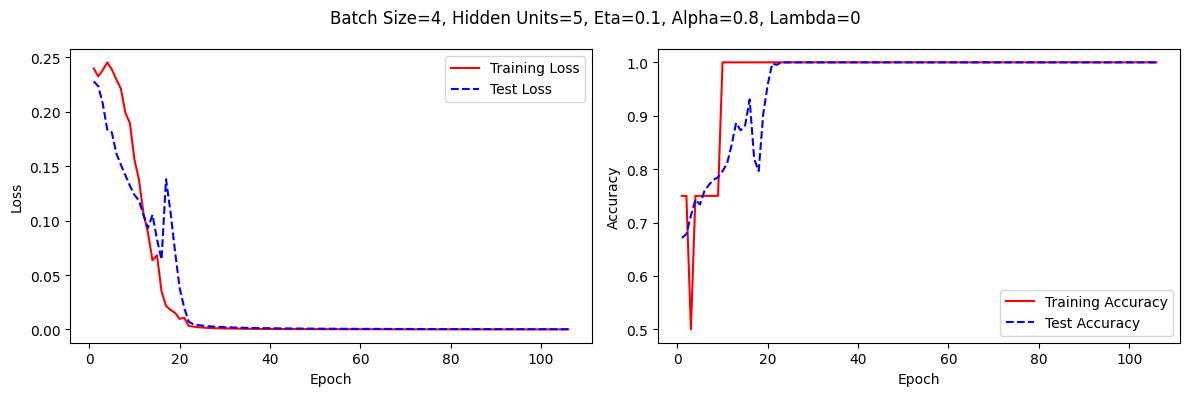

(106, 0.00010471152199897915, 0.0002543215232435614, 1.0, 1.0)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [ ]:
hidden_sizes = [5]
learning_rates = [0.01,0.001]
momentums = [0.8,0.9]
batch_sizes = [1]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.8; batch size = 1; lambda = 0
epoch: 219	batch: 96	Loss =  0.000N. Epochs = 220 - Loss (train | test)= (3.309e-05 | 0.02153) - Accuracy (train | test) = (1.0 | 0.96)
epoch: 72	batch: 96	Loss =  0.000N. Epochs = 73 - Loss (train | test)= (8.856e-08 | 0.1404) - Accuracy (train | test) = (1.0 | 0.84)
epoch: 69	batch: 97	Loss =  0.000N. Epochs = 70 - Loss (train | test)= (2.131e-08 | 0.038) - Accuracy (train | test) = (1.0 | 0.9583333333333334)
epoch: 106	batch: 97	Loss =  0.000N. Epochs = 107 - Loss (train | test)= (8.513e-07 | 0.1303) - Accuracy (train | test) = (1.0 | 0.875)
epoch: 62	batch: 97	Loss =  0.000N. Epochs = 63 - Loss (train | test)= (4.943e-10 | 0.05911) - Accuracy (train | test) = (1.0 | 0.9166666666666666)
Final Results: hidden_size=5; lr=0.01; alpha = 0.8; batch size = 1; lambda = 0 --> train_loss = 6.81e-06 +- 1.314e-05 | val_loss = 0.07785 +- 0.04851train_acc = 1.0 +- 0.0 | val_acc = 0.91 +- 0.04692
hidden_size=5; lr=0.01; alpha = 0.9; 

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

epoch: 120	batch: 121	Loss =  0.000N. Epochs = 121 - Loss (train | test)= (6.418e-06 | 0.04289) - Accuracy (train | test) = (1.0 | 0.9722222222222222)
epoch: 202	batch: 121	Loss =  0.000N. Epochs = 203 - Loss (train | test)= (0.000282 | 0.04194) - Accuracy (train | test) = (1.0 | 0.9606481481481481)
epoch: 125	batch: 121	Loss =  0.000N. Epochs = 126 - Loss (train | test)= (2.963e-06 | 0.04062) - Accuracy (train | test) = (1.0 | 0.9722222222222222)
epoch: 200	batch: 121	Loss =  0.000N. Epochs = 201 - Loss (train | test)= (0.0001988 | 0.03777) - Accuracy (train | test) = (1.0 | 0.9629629629629629)
epoch: 350	batch: 121	Loss =  0.002N. Epochs = 351 - Loss (train | test)= (0.002354 | 0.04103) - Accuracy (train | test) = (1.0 | 0.9537037037037037)
Train Loss: 0.0005688 +- 0.0008991
Test Loss: 0.04085 +- 0.001727
Train Acc: 100.0 +- 0.0 %
Test Acc: 96.44 +- 0.7112 %


epoch: 173	batch: 121	Loss =  0.000N. Epochs = 174 - Loss (train | test)= (0.0001045 | 0.04246) - Accuracy (train | test) = (1.0 | 0.9675925925925926)


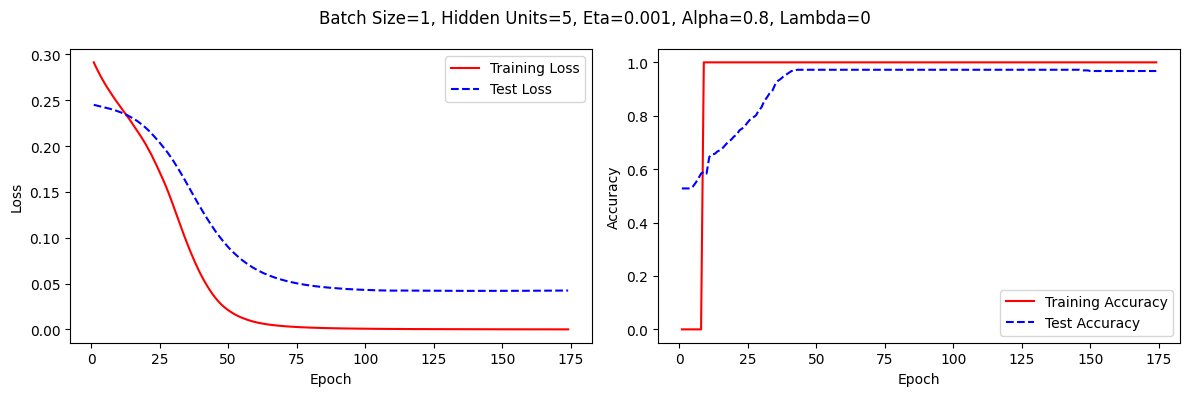

(174, 0.0001045425669872202, 0.042463723570108414, 1.0, 0.9675925925925926)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (with regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [ ]:
hidden_sizes = [5]
learning_rates = [0.01, 0.02,0.005]
momentums = [0.9,0.85,0.95]
batch_sizes = [1]
reg_coeffs = [1e-5,5e-5,5e-6]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.9; batch size = 1; lambda = 1e-05
epoch: 141	batch: 13	Loss =  0.000

KeyboardInterrupt: 

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 1000 - Loss (train | test)= (0.04642 | 0.03986) - Accuracy (train | test) = (0.9426229508196722 | 0.9652777777777778)
N. Epochs = 1000 - Loss (train | test)= (0.05138 | 0.0432) - Accuracy (train | test) = (0.9426229508196722 | 0.9652777777777778)
N. Epochs = 1000 - Loss (train | test)= (0.05111 | 0.04299) - Accuracy (train | test) = (0.9426229508196722 | 0.9675925925925926)
N. Epochs = 1000 - Loss (train | test)= (0.05093 | 0.04271) - Accuracy (train | test) = (0.9426229508196722 | 0.9675925925925926)
N. Epochs = 1000 - Loss (train | test)= (0.04981 | 0.04155) - Accuracy (train | test) = (0.9426229508196722 | 0.9652777777777778)
Train Loss: 0.04993 +- 0.001836
Test Loss: 0.04206 +- 0.00124
Train Acc: 94.26 +- 0.0 %
Test Acc: 96.62 +- 0.1134 %


N. Epochs = 1000 - Loss (train | test)= (0.04728 | 0.03953) - Accuracy (train | test) = (0.9426229508196722 | 0.9652777777777778)


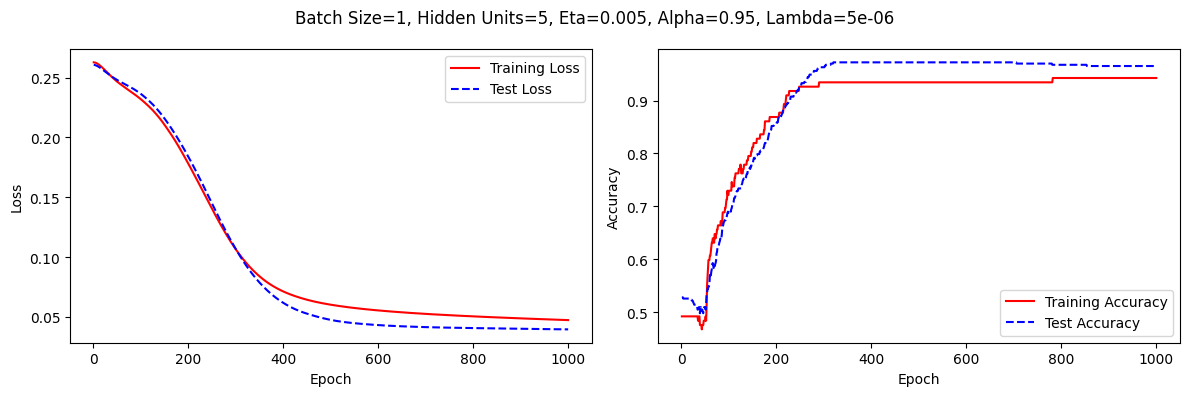

(1000,
 0.047276683151721954,
 0.039525456726551056,
 0.9426229508196722,
 0.9652777777777778)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)